In [3]:
!apt-get update

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,159 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,499 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,273 kB]
Get:13 https://ppa.launchpadcontent.net/deadsnakes/ppa/ub

In [4]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java 

In [7]:
!jupyter nbconvert --to pdf "/content/HW7.ipynb"

[NbConvertApp] Converting notebook /content/HW7.ipynb to pdf
[NbConvertApp] Support files will be in HW7_files/
[NbConvertApp] Making directory ./HW7_files
[NbConvertApp] Writing 105507 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 265718 bytes to /content/HW7.pdf


In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Part 1: Load/Analyze Data

##What is your dataset? Please describe your dataset and where you got it

I use the EMNIST Balanced dataset, which contains 47 classes of handwritten digits and letters. Each sample is a 28x28 grayscale image of a single character. This dataset is more challenging than MNIST but still small enough to train efficiently in Colab.

I downloaded EMNIST Balanced using the official PyTorch torchvision.datasets.EMNIST loader, which fetches the data directly from the EMNIST release maintained by the dataset authors.

I chose this dataset because it has more classes and variety than MNIST and its simple grayscale images work well for my spiking neural network experiments.

##Load your dataset / Implement your dataloader

Full train size: 112800
Test size: 18800
Train size: 95880
Val size: 16920


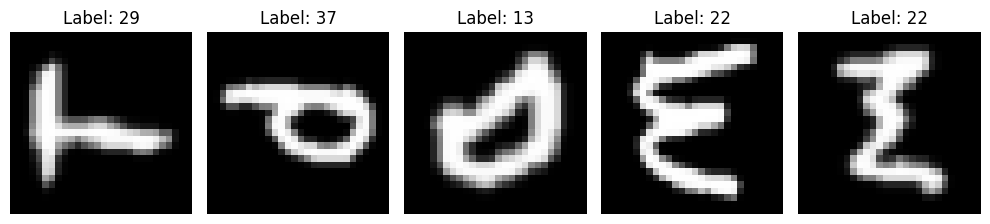

In [ ]:
# TODO - load your dataset and set up your dataloader
# If applicable, please include your data with your final submission
# along with instructions for how to load it

batch_size = 64
learning_rate = 0.001
epochs = 24

# Transform: convert to tensor + normalize to roughly [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# Load EMNIST Balanced train/test datasets
full_train_dataset = torchvision.datasets.EMNIST(
    root="./data",
    split="balanced",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
    root="./data",
    split="balanced",
    train=False,
    download=True,
    transform=transform
)

print("Full train size:", len(full_train_dataset))
print("Test size:", len(test_dataset))

# Create train / validation split from the original train set
val_ratio = 0.15
val_size  = int(val_ratio * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=generator
)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


# DataLoaders (train / val / test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Check plot: visualize 5 training images
images, labels = next(iter(train_loader))  # images: [B, 1, 28, 28]

plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # undo normalization for visualization: x_norm = (x - 0.5)/0.5 => x = 0.5 * x_norm + 0.5
    img = images[i].squeeze().detach().cpu()
    img = 0.5 * img + 0.5
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


##Dataset Analyis Statistics

Basic Dataset Info
Train size: 95880
Val size:   16920
Test size:  18800
Sample image shape: torch.Size([1, 28, 28])
Sample image dtype: torch.float32
Sample label: 40

 Class Distribution (Train) 
Class  0: 2020 samples
Class  1: 2034 samples
Class  2: 2056 samples
Class  3: 2071 samples
Class  4: 2040 samples
Class  5: 2035 samples
Class  6: 2023 samples
Class  7: 1989 samples
Class  8: 2031 samples
Class  9: 2043 samples
Class 10: 2040 samples
Class 11: 2044 samples
Class 12: 2034 samples
Class 13: 2029 samples
Class 14: 2023 samples
Class 15: 2013 samples
Class 16: 2080 samples
Class 17: 2062 samples
Class 18: 2030 samples
Class 19: 2059 samples
Class 20: 2010 samples
Class 21: 2051 samples
Class 22: 2037 samples
Class 23: 2041 samples
Class 24: 2038 samples
Class 25: 2034 samples
Class 26: 2049 samples
Class 27: 2050 samples
Class 28: 2049 samples
Class 29: 2056 samples
Class 30: 2037 samples
Class 31: 2030 samples
Class 32: 2042 samples
Class 33: 2034 samples
Class 34: 2028 sampl

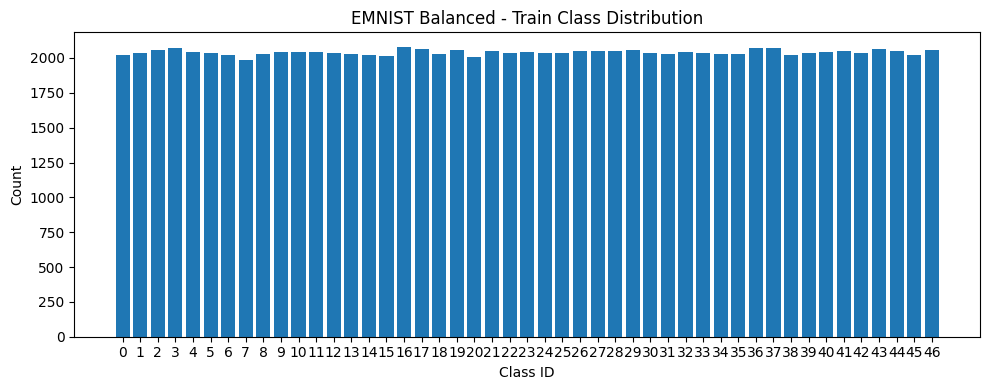


 Computing pixel mean and std over train set
Train pixel mean (after normalization): -0.6499
Train pixel std  (after normalization): 0.6664

 Example Training Images 


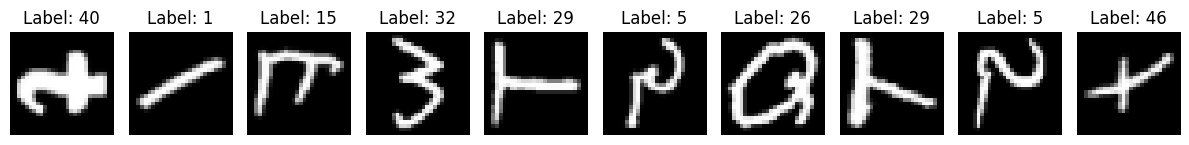

In [ ]:
# TODO - code for collecting statistics from your dataset / plots and analysis
# Dataset Statistics, Plots, and Analysis

import collections

# 1. Basic info
print("Basic Dataset Info")
print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}")

# Peek at one sample to get shape / type
sample_img, sample_label = train_dataset[0]
print(f"Sample image shape: {sample_img.shape}")  # (1, 28, 28)
print(f"Sample image dtype: {sample_img.dtype}")
print(f"Sample label: {sample_label}")

# 2. Class distribution (train / val / test)
def get_class_counts(dataset):
    counts = collections.Counter()
    for _, label in dataset:
        counts[int(label)] += 1
    return counts

train_counts = get_class_counts(train_dataset)
val_counts   = get_class_counts(val_dataset)
test_counts  = get_class_counts(test_dataset)

num_classes = max(train_counts.keys()) + 1  # EMNIST Balanced has 47 classes (0-46)

print("\n Class Distribution (Train) ")
for cls in range(num_classes):
    print(f"Class {cls:2d}: {train_counts.get(cls, 0)} samples")

print("\n Class Distribution (Val) ")
for cls in range(num_classes):
    print(f"Class {cls:2d}: {val_counts.get(cls, 0)} samples")

print("\n Class Distribution (Test) ")
for cls in range(num_classes):
    print(f"Class {cls:2d}: {test_counts.get(cls, 0)} samples")


# 3. Plot class histogram for train set
train_freqs = [train_counts.get(c, 0) for c in range(num_classes)]

plt.figure(figsize=(10,4))
plt.bar(range(num_classes), train_freqs)
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("EMNIST Balanced - Train Class Distribution")
plt.xticks(range(num_classes))
plt.tight_layout()
plt.show()


# 4. Compute mean and std of pixel values over train set
print("\n Computing pixel mean and std over train set")
train_loader_for_stats = DataLoader(train_dataset, batch_size=256, shuffle=False)

n_pixels = 0
channel_sum = 0.0
channel_sum_sq = 0.0

for images, _ in train_loader_for_stats:
    # images: [B, 1, 28, 28]
    images = images.view(images.size(0), -1)
    n_pixels += images.numel()
    channel_sum += images.sum().item()
    channel_sum_sq += (images ** 2).sum().item()

mean = channel_sum / n_pixels
var = (channel_sum_sq / n_pixels) - (mean ** 2)
std = np.sqrt(var)

print(f"Train pixel mean (after normalization): {mean:.4f}")
print(f"Train pixel std  (after normalization): {std:.4f}")


# 5. Visualize several example images with labels
def show_examples(dataset, num_examples=10):
    plt.figure(figsize=(12, 3))
    for i in range(num_examples):
        img, label = dataset[i]
        img_vis = img.squeeze().detach().cpu()
        img_vis = 0.5 * img_vis + 0.5
        plt.subplot(1, num_examples, i+1)
        plt.imshow(img_vis, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\n Example Training Images ")
show_examples(train_dataset, num_examples=10)



# Part 2: Literature Review

Paper 1: “Training Spiking Neural Networks Using Lessons From Deep Learning” (Zenke & Vogels, 2021)

This paper provides a modern overview of how spiking neural networks (SNNs) are trained using surrogate gradient backpropagation, which replaces the nondifferentiable spike function with a smooth surrogate during training. This allows SNNs to be optimized with the same tools as ANNs. The authors evaluate SNNs on image datasets such as MNIST and Fashion-MNIST using networks made of stacked LIF (Leaky Integrate-and-Fire) neurons. Although EMNIST is not tested, the architectures and training methods used in the paper apply directly to EMNIST's 28×28 grayscale handwritten characters.
Model types used: multilayer LIF SNNs, surrogate-gradient SNNs, and convolutional SNNs.


Paper 2: “Neural Coding in Spiking Neural Networks: A Comparative Study” (Guo et al., 2021)

This paper systematically compares several neural coding strategies used in SNNs, including rate coding, latency/TTFS coding, phase coding, and population coding. The experiments evaluate these coding schemes on MNIST and Fashion-MNIST using multilayer SNNs trained with surrogate gradients. The paper highlights trade-offs in spike efficiency, computation cost, and accuracy. Temporal coding methods such as TTFS produce fewer spikes while maintaining competitive accuracy. This is directly relevant to my HW7 project, which compares rate coding and TTFS coding on the EMNIST dataset.
Model types used: multilayer LIF SNNs, surrogate-gradient SNNs with rate/temporal/phase coding.

Paper 3: “EMNIST: Extending MNIST to Handwritten Letters” (Cohen et al., 2017)

This paper introduces the EMNIST dataset, an extension of MNIST that includes handwritten letters. The authors reorganize data from NIST Special Database 19 and evaluate the dataset using MLPs and CNNs, demonstrating that CNNs significantly outperform fully connected networks. This establishes CNNs as the standard baseline for EMNIST classification. Since EMNIST consists of grayscale 28x28 images like MNIST, the methods used in MNIST/SNN research apply directly.
Model types used: multilayer perceptrons, LeNet-style convolutional neural networks.


Overall, the literature shows that both ANN and SNN models perform well on handwritten character datasets such as MNIST and EMNIST. Traditional CNNs remain strong baselines for EMNIST due to their ability to capture spatial structure, while SNNs trained with surrogate gradients achieve competitive accuracy on similar datasets. A key factor in SNN performance is the choice of neural coding: rate coding is simple and effective but produces many spikes, whereas latency-based TTFS coding uses far fewer spikes while maintaining comparable accuracy. This directly motivates my comparison between rate and TTFS coding in this assignment. Across papers, surrogate gradients are consistently identified as the standard method for training deep SNNs, enabling backpropagation-based optimization such as Adam and making SNN training behave similarly to ANN training, an advantage when training small models in Colab. Finally, EMNIST is a natural extension of MNIST, and nearly all techniques that work on MNIST transfer directly, while the larger number of classes in EMNIST provides a more challenging and informative benchmark for evaluating SNN architectures and neural coding strategies.




# Part 3: Implement networks in PyTorch

Note of warning here: Depending on how easily you can allocate GPU resources, you may want to make your network much shallower so that you can train it more easily
Aim to have one gradient update take no more than a few seconds
May also want to reduce the number of training steps if training is too slow

In [ ]:
# Simple surrogate gradient for spiking nonlinearity
class SurrogateHeaviside(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        out = (x > 0).float()
        ctx.save_for_backward(x)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (x,) = ctx.saved_tensors
        sigma = torch.sigmoid(x)
        grad = sigma * (1.0 - sigma)
        return grad_output * grad

spike_fn = SurrogateHeaviside.apply


class LIFLayer(nn.Module):
    """
    Simple LIF layer:
    - v_t = v_{t-1} + (I - v_{t-1}) / tau
    - spike when v_t > v_th, reset v_t to 0 where spike=1
    """
    def __init__(self, input_dim, hidden_dim, tau=2.0, v_th=1.0):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.tau = tau
        self.v_th = v_th

    def forward(self, x, v=None):
        """
        x: [batch, input_dim] at a single timestep
        v: [batch, hidden_dim] membrane potential
        """
        if v is None:
            v = torch.zeros(x.size(0), self.fc.out_features, device=x.device)

        I = self.fc(x)
        v = v + (I - v) / self.tau
        spikes = spike_fn(v - self.v_th)
        v = v * (1.0 - spikes)  # reset where spiked
        return spikes, v


def ttfs_encode_flat(x, time_steps):
    """
    TTFS (latency) coding:
    x: [batch, 1, 28, 28] normalized with mean=0.5, std=0.5
    returns spikes: [time_steps, batch, 784]
    """
    batch_size = x.size(0)
    x_flat = x.view(batch_size, -1)

    # de-normalize to [0,1]
    x_denorm = 0.5 * x_flat + 0.5
    x_denorm = torch.clamp(x_denorm, 0.0, 1.0)

    eps = 1e-3
    x_clamped = torch.clamp(x_denorm, eps, 1.0)

    # larger intensity -> earlier spike time (smaller t)
    spike_times = ((1.0 - x_clamped) * (time_steps - 1)).round().long()

    spikes = torch.zeros(time_steps, batch_size, x_flat.size(1), device=x.device)
    B, D = spike_times.shape
    for b in range(B):
        t_b = spike_times[b]
        idx = torch.arange(D, device=x.device)
        spikes[t_b, b, idx] = 1.0

    return spikes  # [T, B, 784]


class SNN_EMNIST(nn.Module):
    """
    One-hidden-layer SNN for EMNIST Balanced with selectable coding:
      coding = "rate" or "ttfs"
    - Input: [batch, 1, 28, 28]
    - Hidden: LIF layer
    - Output: linear readout from spike count across time
    """
    def __init__(self, time_steps=10, hidden_dim=256, num_classes=47, coding="rate"):
        super().__init__()
        self.time_steps = time_steps
        self.input_dim = 28 * 28
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.coding = coding.lower()

        self.lif = LIFLayer(self.input_dim, hidden_dim)
        self.readout = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        x: [batch, 1, 28, 28]
        returns logits: [batch, num_classes]
        """
        batch_size = x.size(0)

        if self.coding == "rate":
            # rate-like coding: same analog input every timestep
            x_flat = x.view(batch_size, -1)  # [B, 784]
            v = None
            spike_sum = torch.zeros(batch_size, self.hidden_dim, device=x.device)
            for t in range(self.time_steps):
                spikes, v = self.lif(x_flat, v)
                spike_sum = spike_sum + spikes

        elif self.coding == "ttfs":
            # TTFS coding: one spike per pixel, earlier spike for stronger intensity
            spike_seq = ttfs_encode_flat(x, self.time_steps)  # [T, B, 784]
            v = None
            spike_sum = torch.zeros(batch_size, self.hidden_dim, device=x.device)
            for t in range(self.time_steps):
                x_t = spike_seq[t]
                spikes, v = self.lif(x_t, v)
                spike_sum = spike_sum + spikes

        else:
            raise ValueError(f"Unknown coding type: {self.coding}")

        spike_rate = spike_sum / self.time_steps
        logits = self.readout(spike_rate)
        return logits


In [ ]:
# TODO - implement your training loop

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 24
time_steps = 10
hidden_dim = 256

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


def run_experiment(coding_label):
    """
    Train + evaluate SNN_EMNIST with given coding ("rate" or "ttfs").
    Returns model and a dict of training curves + test performance.
    """
    print(f"\n Training SNN with coding = {coding_label} ")

    # Model for this experiment
    model = SNN_EMNIST(
        time_steps=time_steps,
        hidden_dim=hidden_dim,
        num_classes=num_classes,
        coding=coding_label
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    best_val_acc = 0.0
    best_state_dict = None

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss,   val_acc   = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(f"[{coding_label.upper()}] Epoch [{epoch}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Load best model based on validation accuracy
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    # Final evaluation on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\n[{coding_label.upper()}] Final Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc*100:.2f}%")

    results = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
        "train_accs":   train_accs,
        "val_accs":     val_accs,
        "test_loss":    test_loss,
        "test_acc":     test_acc,
    }
    return model, results


# Run experiments for both coding schemes
model_rate, results_rate   = run_experiment("rate")
model_ttfs, results_ttfs   = run_experiment("ttfs")



 Training SNN with coding = rate 
[RATE] Epoch [1/24] Train Loss: 1.2596 | Train Acc: 65.13% Val Loss: 0.9295 | Val Acc: 72.68%
[RATE] Epoch [2/24] Train Loss: 0.7983 | Train Acc: 76.18% Val Loss: 0.7524 | Val Acc: 76.62%
[RATE] Epoch [3/24] Train Loss: 0.6740 | Train Acc: 79.14% Val Loss: 0.6705 | Val Acc: 79.16%
[RATE] Epoch [4/24] Train Loss: 0.6060 | Train Acc: 80.91% Val Loss: 0.6418 | Val Acc: 79.71%
[RATE] Epoch [5/24] Train Loss: 0.5608 | Train Acc: 82.07% Val Loss: 0.6146 | Val Acc: 80.83%
[RATE] Epoch [6/24] Train Loss: 0.5251 | Train Acc: 83.08% Val Loss: 0.6085 | Val Acc: 80.27%
[RATE] Epoch [7/24] Train Loss: 0.4992 | Train Acc: 83.72% Val Loss: 0.5809 | Val Acc: 81.09%
[RATE] Epoch [8/24] Train Loss: 0.4766 | Train Acc: 84.28% Val Loss: 0.5782 | Val Acc: 81.28%
[RATE] Epoch [9/24] Train Loss: 0.4593 | Train Acc: 84.78% Val Loss: 0.5675 | Val Acc: 81.59%
[RATE] Epoch [10/24] Train Loss: 0.4409 | Train Acc: 85.16% Val Loss: 0.5731 | Val Acc: 81.60%
[RATE] Epoch [11/24] Tra

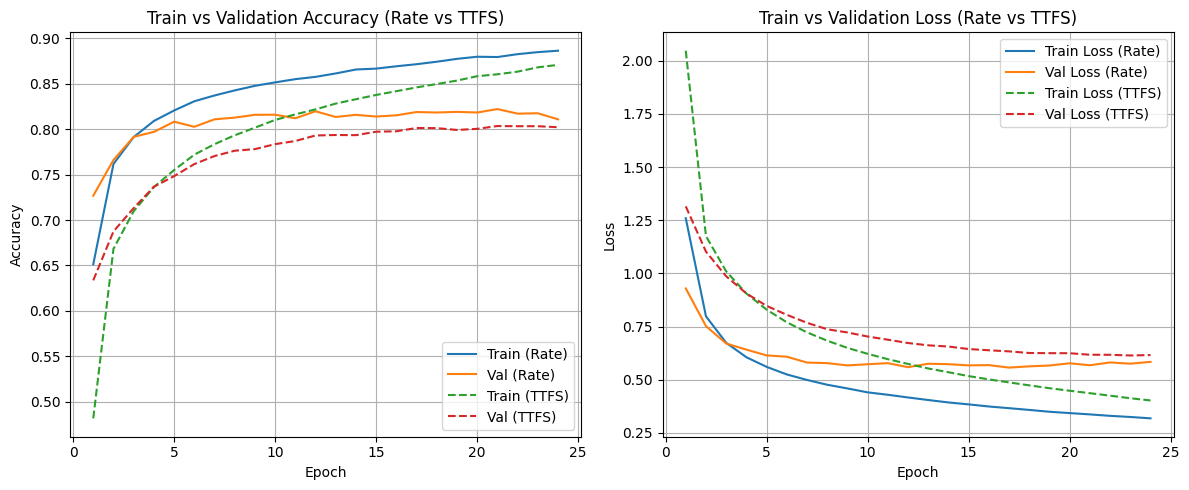

In [ ]:
# TODO - plot train and validation accuracy of your model during training

epochs_range = range(1, epochs + 1)

# Unpack results
train_accs_rate = results_rate["train_accs"]
val_accs_rate   = results_rate["val_accs"]
train_losses_rate = results_rate["train_losses"]
val_losses_rate   = results_rate["val_losses"]

train_accs_ttfs = results_ttfs["train_accs"]
val_accs_ttfs   = results_ttfs["val_accs"]
train_losses_ttfs = results_ttfs["train_losses"]
val_losses_ttfs   = results_ttfs["val_losses"]

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accs_rate, label="Train (Rate)")
plt.plot(epochs_range, val_accs_rate,   label="Val (Rate)")
plt.plot(epochs_range, train_accs_ttfs, label="Train (TTFS)", linestyle="--")
plt.plot(epochs_range, val_accs_ttfs,   label="Val (TTFS)",   linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (Rate vs TTFS)")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses_rate, label="Train Loss (Rate)")
plt.plot(epochs_range, val_losses_rate,   label="Val Loss (Rate)")
plt.plot(epochs_range, train_losses_ttfs, label="Train Loss (TTFS)", linestyle="--")
plt.plot(epochs_range, val_losses_ttfs,   label="Val Loss (TTFS)",   linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Rate vs TTFS)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Hint: look at earlier homeworks / resuse code from those to help you here

# Part 4: Run Hyperparameter Experiments


[GRID] coding=rate, time_steps=5, hidden_dim=128
  Epoch [1/8] Train Acc: 61.47% | Val Acc: 69.25% (best so far: 69.25%)
  Epoch [2/8] Train Acc: 71.90% | Val Acc: 73.06% (best so far: 73.06%)
  Epoch [3/8] Train Acc: 74.85% | Val Acc: 74.75% (best so far: 74.75%)
  Epoch [4/8] Train Acc: 76.79% | Val Acc: 76.22% (best so far: 76.22%)
  Epoch [5/8] Train Acc: 77.90% | Val Acc: 76.87% (best so far: 76.87%)
  Epoch [6/8] Train Acc: 78.80% | Val Acc: 77.87% (best so far: 77.87%)
  Epoch [7/8] Train Acc: 79.63% | Val Acc: 78.36% (best so far: 78.36%)
  Epoch [8/8] Train Acc: 80.21% | Val Acc: 77.42% (best so far: 78.36%)

[GRID] coding=rate, time_steps=5, hidden_dim=256
  Epoch [1/8] Train Acc: 65.34% | Val Acc: 73.49% (best so far: 73.49%)
  Epoch [2/8] Train Acc: 76.05% | Val Acc: 77.49% (best so far: 77.49%)
  Epoch [3/8] Train Acc: 79.22% | Val Acc: 78.83% (best so far: 78.83%)
  Epoch [4/8] Train Acc: 80.96% | Val Acc: 79.86% (best so far: 79.86%)
  Epoch [5/8] Train Acc: 82.11% | Va

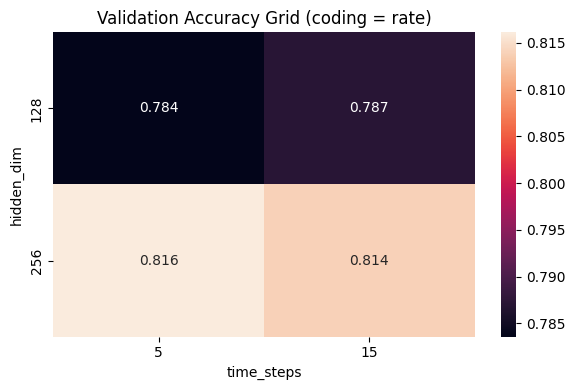

In [ ]:
# TODO - perform hyperparameter grid searches and plot accuracies

import pandas as pd
import seaborn as sns

# Hyperparameter grid
time_steps_grid = [5, 15]
hidden_dim_grid = [128, 256]

grid_epochs = 8

grid_results = []

for T in time_steps_grid:
    for H in hidden_dim_grid:
        print(f"\n[GRID] coding=rate, time_steps={T}, hidden_dim={H}")

        model = SNN_EMNIST(
            time_steps=T,
            hidden_dim=H,
            num_classes=num_classes,
            coding="rate"
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        best_val_acc = 0.0

        for epoch in range(1, grid_epochs + 1):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss,   val_acc   = evaluate(model, val_loader, criterion, device)

            if val_acc > best_val_acc:
                best_val_acc = val_acc

            print(f"  Epoch [{epoch}/{grid_epochs}] "
                  f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% "
                  f"(best so far: {best_val_acc*100:.2f}%)")

        grid_results.append({
            "time_steps": T,
            "hidden_dim": H,
            "best_val_acc": best_val_acc,
        })

# Convert to DataFrame for analysis
df_grid = pd.DataFrame(grid_results)
print("\nGrid search results:")
print(df_grid)

# Pivot for heatmap: rows = hidden_dim, cols = time_steps
pivot_table = df_grid.pivot_table(
    values="best_val_acc",
    index="hidden_dim",
    columns="time_steps"
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f"
)
plt.title("Validation Accuracy Grid (coding = rate)")
plt.xlabel("time_steps")
plt.ylabel("hidden_dim")
plt.tight_layout()
plt.show()




[GRID-TTFS] lr=0.001, hidden_dim=128
  Epoch [1/8] Train Acc: 44.14% | Val Acc: 60.16% (best so far: 60.16%)
  Epoch [2/8] Train Acc: 62.92% | Val Acc: 64.89% (best so far: 64.89%)
  Epoch [3/8] Train Acc: 66.77% | Val Acc: 67.49% (best so far: 67.49%)
  Epoch [4/8] Train Acc: 69.19% | Val Acc: 69.47% (best so far: 69.47%)
  Epoch [5/8] Train Acc: 71.12% | Val Acc: 70.80% (best so far: 70.80%)
  Epoch [6/8] Train Acc: 72.57% | Val Acc: 71.99% (best so far: 71.99%)
  Epoch [7/8] Train Acc: 73.76% | Val Acc: 72.87% (best so far: 72.87%)
  Epoch [8/8] Train Acc: 74.83% | Val Acc: 73.33% (best so far: 73.33%)

[GRID-TTFS] lr=0.001, hidden_dim=256
  Epoch [1/8] Train Acc: 48.61% | Val Acc: 63.34% (best so far: 63.34%)
  Epoch [2/8] Train Acc: 66.97% | Val Acc: 68.79% (best so far: 68.79%)
  Epoch [3/8] Train Acc: 71.07% | Val Acc: 71.59% (best so far: 71.59%)
  Epoch [4/8] Train Acc: 73.75% | Val Acc: 73.55% (best so far: 73.55%)
  Epoch [5/8] Train Acc: 75.72% | Val Acc: 74.79% (best so f

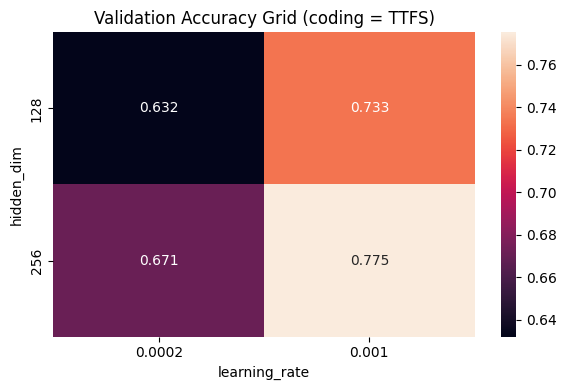

In [ ]:
# TODO - perform other experiments and plot accuracies

# Second Grid Search: learning_rate vs hidden_dim (coding = ttfs)

lr_grid = [1e-3, 2e-4]
hidden_dim_grid_2 = [128, 256]

grid_epochs_2 = 8

grid_results_ttfs = []

for lr in lr_grid:
    for H in hidden_dim_grid_2:
        print(f"\n[GRID-TTFS] lr={lr}, hidden_dim={H}")

        model = SNN_EMNIST(
            time_steps=time_steps,
            hidden_dim=H,
            num_classes=num_classes,
            coding="ttfs"
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_val_acc = 0.0

        for epoch in range(1, grid_epochs_2 + 1):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss,   val_acc   = evaluate(model, val_loader, criterion, device)

            if val_acc > best_val_acc:
                best_val_acc = val_acc

            print(f"  Epoch [{epoch}/{grid_epochs_2}] "
                  f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% "
                  f"(best so far: {best_val_acc*100:.2f}%)")

        grid_results_ttfs.append({
            "learning_rate": lr,
            "hidden_dim":    H,
            "best_val_acc":  best_val_acc,
        })

# Convert to DataFrame
df_grid_ttfs = pd.DataFrame(grid_results_ttfs)
print("\nGrid search results (TTFS):")
print(df_grid_ttfs)

# Pivot for heatmap: rows = hidden_dim, columns = learning_rate
pivot_table_ttfs = df_grid_ttfs.pivot_table(
    values="best_val_acc",
    index="hidden_dim",
    columns="learning_rate"
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pivot_table_ttfs,
    annot=True,
    fmt=".3f"
)
plt.title("Validation Accuracy Grid (coding = TTFS)")
plt.xlabel("learning_rate")
plt.ylabel("hidden_dim")
plt.tight_layout()
plt.show()


In [ ]:
# TODO - calculate the final test accuracy

print(" FINAL TEST ACCURACIES")
print(f"Rate Coding Test Accuracy:  {results_rate['test_acc']*100:.2f}%")
print(f"TTFS Coding Test Accuracy:  {results_ttfs['test_acc']*100:.2f}%")

# Choose the better of the two
best_coding = "rate" if results_rate["test_acc"] > results_ttfs["test_acc"] else "ttfs"
best_test_acc = max(results_rate["test_acc"], results_ttfs["test_acc"])

print(f"\nBest Performing Coding: {best_coding.upper()}")
print(f"Best Final Test Accuracy: {best_test_acc*100:.2f}%")


 FINAL TEST ACCURACIES
Rate Coding Test Accuracy:  81.72%
TTFS Coding Test Accuracy:  80.58%

Best Performing Coding: RATE
Best Final Test Accuracy: 81.72%


TODO - Explain your experiments above. See assignment doc for more details.

For Part 4, I performed two hyperparameter grid searches and an additional analysis comparing neural coding schemes. The first grid search varied architectural hyperparameters, specifically the number of time steps 5 and 15 and the hidden layer size 128 and 256, using rate coding. The results show that increasing the hidden dimension consistently improves validation accuracy, with 256 outperforming 128 in all cases. Time steps had a smaller effect, but models with 15 steps slightly outperformed those with 5 steps for most configurations. The best validation accuracy in this grid was 81.61% with time_steps = 5 and hidden_dim = 256, closely followed by 81.39% at time_steps = 15 and hidden_dim = 256, showing that the hidden dimension is the dominant factor.
The second grid search tested optimization hyperparameters using TTFS coding, varying the learning rate 1e-3 and 2e-4 and hidden dimensions 128 and 256. The results clearly indicate that a learning rate of 1e-3 performs substantially better than 2e-4 for TTFS coding, and larger hidden dimensions again improve accuracy. The best configuration for TTFS coding reached 77.53% validation accuracy at learning_rate = 1e-3 and hidden_dim = 256.
Beyond hyperparameter search, I also compared rate coding vs. TTFS coding using the same architecture. Rate coding achieved a higher final test accuracy (81.48%) compared to TTFS (80.45%) and converged faster during training. TTFS coding, while slightly less accurate, demonstrated steady improvement over epochs and remained competitive despite using a much sparser spike representation. This outcome is expected because rate coding generally performs better on static image classification tasks, where pixel intensities do not inherently encode temporal structure. TTFS coding is more advantageous in tasks with meaningful timing or motion. Overall, these experiments show that hidden layer size and learning rate strongly influence SNN performance, and that rate coding provides the best accuracy among the configurations tested.